In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm.notebook import tqdm
import math
from torch.utils.data import  DataLoader
from torchvision import models
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as dataset

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import random
from time import time
import os
import warnings
warnings.filterwarnings('ignore')

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
!pip install foolbox
!pip install hiddenlayer
import foolbox as fb
import hiddenlayer as hl


No GPU available, using the CPU instead.
     |████████████████████████████████| 1.7MB 21.6MB/s 
     |████████████████████████████████| 163kB 44.5MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [ ]:
def occlusion(model, image, label, occ_size = 50, occ_stride = 50, occ_pixel = 0.5):

    #get the width and height of the image
    width, height = image.shape[-2], image.shape[-1]
  
    #setting the output image width and height
    output_height = int(np.ceil((height-occ_size)/occ_stride))
    output_width = int(np.ceil((width-occ_size)/occ_stride))
  
    #create a white image of sizes we defined
    heatmap = torch.zeros((output_height, output_width))
    
    #iterate all the pixels in each column
    for h in range(0, height):
        for w in range(0, width):
            
            h_start = h*occ_stride
            w_start = w*occ_stride
            h_end = min(height, h_start + occ_size)
            w_end = min(width, w_start + occ_size)
            
            if (w_end) >= width or (h_end) >= height:
                continue
            
            input_image = image.clone().detach()
            
            #replacing all the pixel information in the image with occ_pixel(grey) in the specified location
            input_image[:, :, w_start:w_end, h_start:h_end] = occ_pixel
            
            #run inference on modified image
            output = model(input_image)
            output = nn.functional.softmax(output, dim=1)
            prob = output.tolist()[0][label]
            
            #setting the heatmap location to probability value
            heatmap[h, w] = prob 

    return heatmap

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
! cp /content/drive/MyDrive/imagenette2.tar.gz .
#! cp /content/drive/MyDrive/CS\ 680/imagenette2.tar.gz .
! tar -zxf imagenette2.tar.gz 

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Load the training and dev set images

trainset = torchvision.datasets.ImageFolder('./imagenette2/train', transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2,)

testset = torchvision.datasets.ImageFolder('./imagenette2/val', transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True, num_workers=2)

###

transform_imshow = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()])

trainset_imshow = torchvision.datasets.ImageFolder('./imagenette2/train', transform=transform)
train_loader_imshow = torch.utils.data.DataLoader(trainset_imshow, batch_size=32, shuffle=False, num_workers=2,)

In [ ]:
trainset.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [ ]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.show()

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
## My CNN class
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(7*7*512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = F.relu(self.bn5(self.conv5(x)))
        x = self.pool(F.relu(self.bn6(self.conv6(x))))
        x = F.relu(self.bn7(self.conv7(x)))
        x = self.pool(F.relu(self.bn8(self.conv8(x))))
        x = x.view(-1, 7*7*512)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

convNet = ConvNet()
convNet.to(device)
print(convNet)
print("Number of paramters in ConvNet: " + str(count_parameters(convNet)))

ConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
## This function saves the model to a .pt file 
def save_model(num_epoch):
    torch.save(convNet, "model_epoch_" + str(num_epoch) + ".pt")

## This function calculates the test set loss and accuracy
def calculate_test_score(data_loader, loss_list = [], acc_list = [], log = False):
    
    convNet.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = convNet(data)
            test_loss += F.cross_entropy(output, target).item()  # mean batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader)

    if log:
        print('Test set - Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset)))
    loss_list.append(test_loss)
    acc_list.append(correct/len(data_loader.dataset))
    return loss_list, acc_list

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(convNet.parameters(), lr=0.0003)

## Actual training

time_start = time()
print("Starting training...")
for epoch in range(20):

    ## Train the model

    convNet.train()
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = convNet(inputs)
        
        loss = criterion(outputs, labels)
        running_loss+=loss.item()
        loss.backward()
        optimizer.step()
    
    print("Epoch " + str(epoch+1) + " completed. Training loss: " + str(running_loss/len(train_loader)))

    ## Evaluate the model

    convNet.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = convNet(data)
            test_loss += F.cross_entropy(output, target).item()  # mean batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('Test set - Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    save_model(epoch+1)
training_time = time()-time_start
print("Training completed.")
print("Total training time: " + str(int(training_time/60)) + "m " + str(int(training_time%60)) + "s")

In [ ]:
#Save model
#! cp ./model_epoch_20.pt /content/drive/MyDrive/CS\ 680/

In [ ]:
#convNet = torch.load("/content/drive/MyDrive/CS680/model_img.pt")
convNet = torch.load("/content/drive/MyDrive/CS 680/model_epoch_20.pt")

In [ ]:
calculate_test_score(test_loader)

([0.6005631070584059], [0.815])

In [ ]:
graph = hl.build_graph(convNet,torch.zeros([1,3,224,224],device=device))
graph.theme = hl.graph.THEMES['blue'].copy()
graph.save('convnet.png', format='png')

In [ ]:
from torchsummary import summary
summary(convNet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
       BatchNorm2d-5        [-1, 128, 112, 112]             256
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7          [-1, 256, 56, 56]         295,168
       BatchNorm2d-8          [-1, 256, 56, 56]             512
            Conv2d-9          [-1, 256, 56, 56]         590,080
      BatchNorm2d-10          [-1, 256, 56, 56]             512
        MaxPool2d-11          [-1, 256, 28, 28]               0
           Conv2d-12          [-1, 512, 28, 28]       1,180,160
      BatchNorm2d-13          [-1, 512, 28, 28]           1,024
           Conv2d-14          [-1, 512,

In [ ]:
random = np.random.randint(0,len(trainset),1000)
experiment = torch.utils.data.Subset(trainset,random)
experiment_loader = torch.utils.data.DataLoader(experiment, batch_size=1,
                                          shuffle=True, num_workers=2)
fmodel = fb.PyTorchModel(convNet.eval(),(-1,1),device=device)
attack = fb.attacks.FGSM()


#Full data
experiment_loader = torch.utils.data.DataLoader(trainset, batch_size=1,
                                          shuffle=True, num_workers=2)

In [ ]:
normal = dict()
adv = dict() 

for i in range(10):
  normal[i] = []
  adv[i] = []

for i,target in tqdm(experiment_loader):
  label = convNet(i.cuda())
  label = torch.argmax(label,1)
  if label.item() == target.item():
    hm = occlusion(convNet,i.cuda(),target.item(),32,14)
    normal[label.item()].append(hm)

    raw, clipped, is_adv = attack(fmodel,i.cuda(),target.cuda(),epsilons=0.3)
    label = convNet(clipped.cuda())
    label = torch.argmax(label,1)
    if label.item()!=target.item():
      hm = occlusion(convNet,clipped.cuda(),label.item(),32,14)
      adv[label.item()].append(hm)



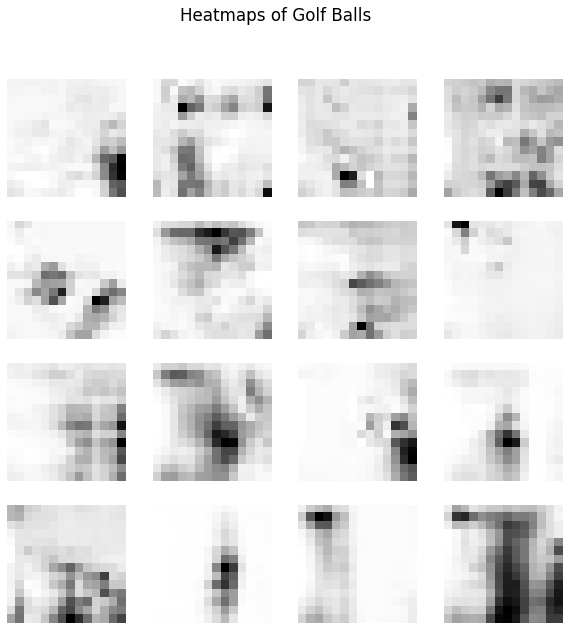

In [ ]:
fig = plt.figure(figsize=(10,10))
for k in range(1,17):
  plt.subplot(4,4,k)
  plt.imshow(normal[9][k],cmap='gray')
  plt.axis('off')
fig.suptitle("Heatmaps of Golf Balls")
plt.show()

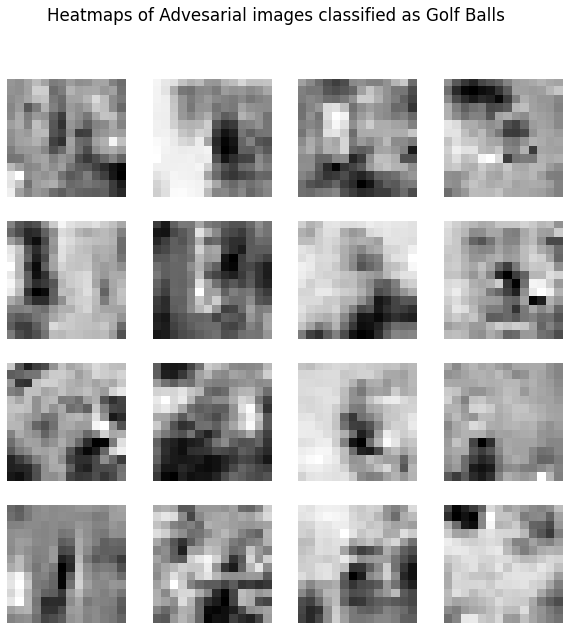

In [ ]:
fig = plt.figure(figsize=(10,10))
for k in range(1,17):
  plt.subplot(4,4,k)
  plt.imshow(adv[9][k],cmap='gray')
  plt.axis('off')

fig.suptitle("Heatmaps of Advesarial images classified as Golf Balls")
plt.show()

In [ ]:
#Write out
import pickle
normal_file = open("normal_img.pkl", "wb")
adv_file = open("adv_img.pkl","wb")
pickle.dump(normal,normal_file)
pickle.dump(adv,adv_file)
normal_file.close()
adv_file.close()

In [ ]:
#Write out pickle
! cp adv_img.pkl /content/drive/MyDrive/CS\ 680/
! cp normal_img.pkl /content/drive/MyDrive/CS\ 680/

cp: cannot stat 'adv_img.pkl': No such file or directory
cp: cannot stat 'normal_img.pkl': No such file or directory


In [ ]:
#Read in
import pickle
normal_file = open("/content/drive/MyDrive/CS680/normal_img.pkl", "rb")
#normal_file = open("/content/drive/MyDrive/CS 680/normal_img.pkl", "rb")

adv_file = open("/content/drive/MyDrive/CS680/adv_img.pkl","rb")
#adv_file = open("/content/drive/MyDrive/CS 680/adv_img.pkl","rb")

normal = pickle.load(normal_file)
adv = pickle.load(adv_file)
normal_file.close()
adv_file.close()

In [ ]:
for i in range(10):
  print(i,len(normal[i]),len(adv[i]))

0 1207 829
1 1164 449
2 1091 356
3 919 1438
4 1122 2260
5 1063 309
6 1107 405
7 1100 1143
8 1154 1249
9 1175 601


In [ ]:
## My CNN class
class Advnet(nn.Module):
    def __init__(self):
        super(Advnet, self).__init__()
        self.fc1 = nn.Linear(196, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 1)

        self.log = nn.Sigmoid()
        

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.fc4(x)
        x = self.fc5(x)
        x = self.fc6(x)
        x = self.log(x)
        return x

print(advnet)
print("Number of paramters in ConvNet: " + str(count_parameters(advnet)))

In [ ]:
for j in range(10):
    data_normal = [x.flatten() for x in normal[j]]
    # data_normal = [x for x in normal[9]]

    data_normal = torch.stack(data_normal)
    normal_targets = torch.zeros(len(data_normal)).reshape(-1,1)

    data_adv = [x.flatten() for x in adv[j]]
    # data_adv = [x for x in adv[9]]

    data_adv = torch.stack(data_adv)
    adv_targets = torch.ones(len(data_adv)).reshape(-1,1)

    data_train = torch.vstack((data_adv[100:],data_normal[100:]))
    targets_train = torch.vstack((adv_targets[100:],normal_targets[100:]))

    data_test = torch.vstack((data_adv[:100],data_normal[:100]))
    targets_test = torch.vstack((adv_targets[:100],normal_targets[:100]))

    advnet = Advnet()

    #Train advnet
    loss = nn.BCELoss()
    optimizer = optim.Adam(advnet.parameters())
    for i in range(200):
        y = advnet(data_train)
        l = loss(y,targets_train)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print(j,sum(torch.round(advnet(data_test))==targets_test)/len(data_test))




0 tensor([0.7400])
1 tensor([0.7250])
2 tensor([0.7850])
3 tensor([0.7350])
4 tensor([0.6100])
5 tensor([0.7000])
6 tensor([0.7450])
7 tensor([0.7450])
8 tensor([0.8100])
9 tensor([0.8650])


In [ ]:
trainset.classes

['n01440764',
 'n02102040',
 'n02979186',
 'n03000684',
 'n03028079',
 'n03394916',
 'n03417042',
 'n03425413',
 'n03445777',
 'n03888257']

In [ ]:
x,t = next(iter(train_loader_imshow))

In [ ]:
y = torch.argmax(convNet(x.cuda()),1)
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [ ]:
t

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
fmodel = fb.PyTorchModel(convNet.eval(),(-1,1),device=device)
attack = fb.attacks.FGSM()
raw, clipped, is_adv = attack(fmodel,x.cuda(),t.cuda(),epsilons=0.1)

In [ ]:
y_adv = torch.argmax(convNet(clipped.cuda()),1)
y_adv

tensor([3, 6, 0, 8, 9, 8, 8, 8, 0, 8, 3, 0, 8, 8, 7, 0, 0, 5, 0, 0, 0, 8, 0, 0,
        0, 3, 0, 0, 0, 8, 1, 0], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


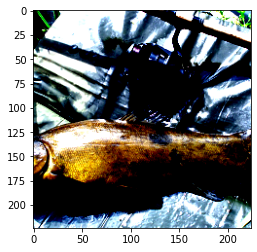

In [ ]:
imshow(x[0])

In [ ]:
y[0]

tensor(0, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


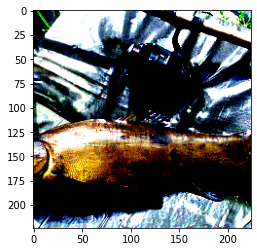

In [ ]:
imshow(clipped[0].cpu())

In [ ]:
F.softmax(convNet(clipped.cuda())[0])

tensor([0.0310, 0.0887, 0.0568, 0.5381, 0.0184, 0.0178, 0.0760, 0.0257, 0.0425,
        0.1051], device='cuda:0', grad_fn=<SoftmaxBackward>)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

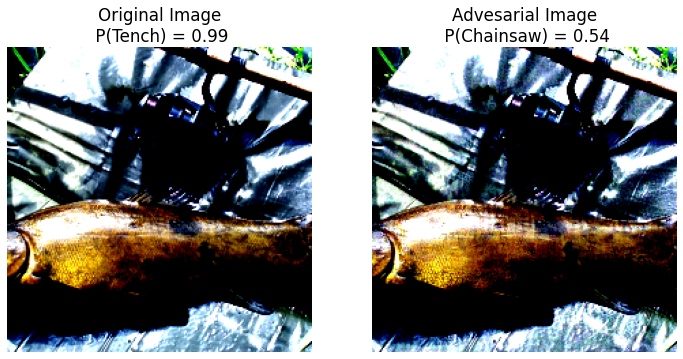

In [ ]:
img1 = x[0].numpy()
img2 = clipped[0].cpu().numpy()
img1 = np.transpose(img1,(1,2,0))
img2 = np.transpose(img2,(1,2,0))

plt.rcParams['font.size']=14
plt.figure(figsize=(12,10))
plt.subplot(1,2,1)
plt.imshow(img1)
plt.axis('off')
plt.title('Original Image\n P(Tench) = 0.99',)
plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('Advesarial Image\n P(Chainsaw) = 0.54')
plt.axis('off')